In [26]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

In [27]:
#Problem 1

In [28]:
#a

In [29]:
df=pd.read_csv("data/incomes.txt",names=['Income'])

(1, 150000)

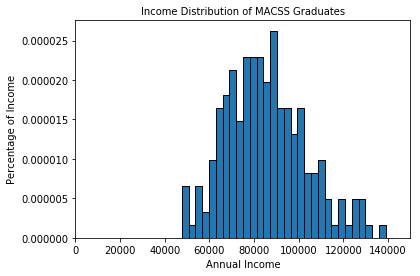

In [30]:
bins = 30
plt.hist(df['Income'], bins, normed = True, edgecolor = 'k')
plt.title('Income Distribution of MACSS Graduates', fontsize = 10)
plt.xlabel('Annual Income')
plt.ylabel('Percentage of Income')
plt.xlim([1, 150000])

In [31]:
#b

In [32]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))) /
                    prob_notcut)
    
    return pdf_vals

In [33]:
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    return mean_model, np.sqrt(var_model)


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [34]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (df['Income'], 0.0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)

mean_data, std_data = data_moments(df['Income'])
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation of model =', std_model)
print('Error vector =', err1)
print('GMM criterion function:',results.fun)

mu_GMM1 = 11.33353348254703  sig_GMM1 = 0.2138619143524033
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894193 , Standard Deviation of model = 18037.69242475689
Error vector = [ 5.30840417e-09 -2.46491986e-08]
GMM criterion function: [[6.35762147e-16]]


/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


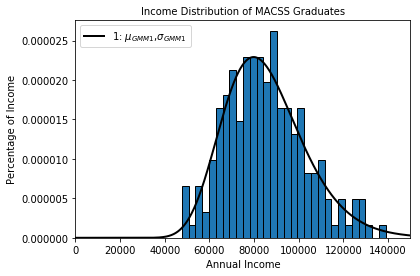

In [36]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Income Distribution of MACSS Graduates', fontsize=10)
plt.xlabel('Annual Income')
plt.ylabel('Percentage of Income')
plt.xlim([1, 150000])  

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

In [56]:
#c

In [37]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [38]:
Err_mat =get_Err_mat2(df['Income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / df['Income'].shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2:","\n",VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2:","\n",W_hat2)

VCV2: 
 [[4.45167060e-02 1.67963797e+03]
 [1.67963797e+03 9.49413425e+08]]
W_hat2: 
 [[ 2.40701669e+01 -4.25833101e-05]
 [-4.25833101e-05  1.12861743e-09]]


In [39]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2 =', mu_GMM2, ' sig_GMM2 =', sig_GMM2)

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(df['Income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector =', err2)
print('GMM criterion function:',results2.fun)

mu_GMM2 = 11.333533472755567  sig_GMM2 = 0.21386191374148283
Mean of points = 85276.82360625808 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82324668273 , Standard Deviation of model = 18037.6922484816
Error vector = [-4.21656596e-09 -3.44218060e-08]
GMM criterion function: [[4.27941452e-16]]


/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


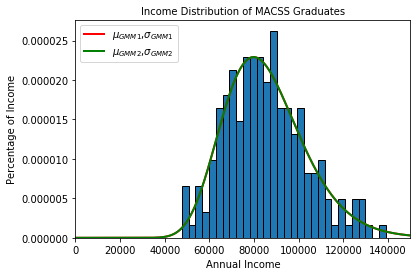

In [40]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Income Distribution of MACSS Graduates', fontsize=10)
plt.xlabel('Annual Income')
plt.ylabel('Percentage of Income')
plt.xlim([1, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the estimated GMM PDF with weighting matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='g', label='$\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

In [41]:
#d

In [42]:

def data_moments3(xvals):

    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):

    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):

    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion3(params, *args):

    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [43]:
W_hat1_3 = np.eye(3)
gmm_args = (df['Income'], 0.0, 150000.0, W_hat1_3)

results3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results3.x
print('mu_GMM1_3 =', mu_GMM1_3, ' sig_GMM1_3 =', sig_GMM1_3)
err3 = err_vec3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

bpct_1_dat, bpct_2_dat, bpct_3_dat=data_moments3(df['Income'])
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector =', err3)
print('GMM criterion function:',results3.fun)
df2=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Moments':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
df2

mu_GMM1_3 = 11.336705162764707  sig_GMM1_3 = 0.21151353494384176
Error vector = [ 1.61522379e-07 -7.19526623e-08 -6.24019113e-08]
GMM criterion function: [[3.51606631e-14]]


,Data Moments,Model Moments
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


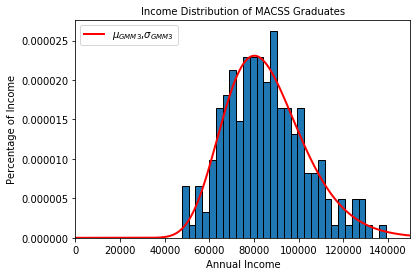

In [44]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed = True, edgecolor = 'k')
plt.title('Income Distribution of MACSS Graduates', fontsize=10)
plt.xlabel('Annual Income')
plt.ylabel('Percentage of Income')
plt.xlim([1, 150000])

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='r', label='$\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

In [45]:
#e

In [46]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [47]:
Err_mat3 = get_Err_mat3(df['Income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3 = (1 / df['Income'].shape[0]) * (Err_mat3 @ Err_mat3.T)
print("VCV2_3:","\n",VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print("W_hat2_3","\n",W_hat2_3)

VCV2_3: 
 [[ 2.33333258 -0.99999991 -0.9999999 ]
 [-0.99999991  1.00000014 -1.00000013]
 [-0.9999999  -1.00000013  4.0000005 ]]
W_hat2_3 
 [[ 0.25761775 -0.14958453 -0.01246539]
 [-0.14958453  0.11911361 -0.07340718]
 [-0.01246539 -0.07340718  0.20221604]]


In [48]:
gmm_args = (df['Income'], 0.0, 150000.0, W_hat2_3)

results4 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM1_3w, sig_GMM1_3w = results4.x
print('mu_GMM1_3w =', mu_GMM1_3, ' sig_GMM1_3w =', sig_GMM1_3)
err3w = err_vec3(df['Income'], mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0)

print('Error vector =', err3w)
print('GMM criterion function:',results4.fun)
df3 = pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Moments':[pert1, pert2, pert3]},
                index=['Percent <75000','Percent 75000~100000','Percent >=100000'])
df3

mu_GMM1_3w = 11.336705162764707  sig_GMM1_3w = 0.21151353494384176
Error vector = [ 5.84568507e-07 -3.06908001e-07 -1.09582757e-07]
GMM criterion function: [[1.52014071e-13]]


,Data Moments,Model Moments
Percent <75000,0.3,0.3
Percent 75000~100000,0.5,0.5
Percent >=100000,0.2,0.2


/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/fangrl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


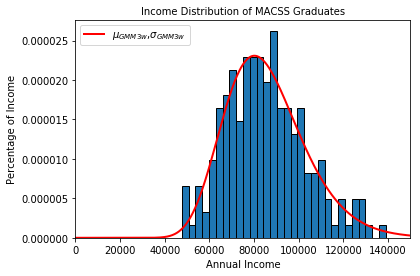

In [49]:
num_bins = 30
plt.hist(df['Income'], num_bins, normed=True, edgecolor='k')
plt.title('Income Distribution of MACSS Graduates', fontsize=10)
plt.xlabel('Annual Income')
plt.ylabel('Percentage of Income')
plt.xlim([1, 150000])
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth=2, color='r', label='$\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc='upper left')

In [50]:
#f

In [51]:
mu=[mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM1_3w]
sig=[sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM1_3w]
GMMV=[results.fun,results2.fun,results3.fun,results4.fun]
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Value":GMMV}
            ,index=['2 moments&Identity Matrix','2 moments&Weighted Matrix',
                   '3 moments&Identity Matrix','3 moments&Weighted Matrix']).astype(float)

,GMM Value,mu,sigma
2 moments&Identity Matrix,6.357621e-16,11.333533,0.213862
2 moments&Weighted Matrix,4.279415e-16,11.333533,0.213862
3 moments&Identity Matrix,3.516066e-14,11.336705,0.211514
3 moments&Weighted Matrix,1.520141e-13,11.336705,0.211514


The estimation from part c fits the data best. Because it uses two-step optimal weighting.

In [52]:
#Problem 2

In [53]:
dfs = pd.read_csv("data/sick.txt").astype('float64')

In [54]:
def err_vecs(dfs, b0, b1, b2, b3):
    yhat = b0 + b1 * dfs['age'] + b2 * dfs['children'] + b3 * dfs['avgtemp_winter']
    y = dfs['sick']
    err_vecs = yhat - y
    err_vecs = np.array(err_vecs)
    return err_vecs

def criterions(params, *args):

    b0, b1, b2, b3 = params
    dfs, W = args
    err = err_vecs(dfs, b0, b1, b2, b3)
    crit_vals = err.T @ W @ err
    
    return crit_vals

In [55]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(dfs.shape[0])
gmm_args = (dfs, W_hat)
results = opt.minimize(criterions, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = results.x
print("Estimation of b0",b0)
print("Estimation of b1",b1)
print("Estimation of b2",b2)
print("Estimation of b3",b3)
print('GMM criterion function:',results.fun)

Estimation of b0 0.25164486366268873
Estimation of b1 0.012933470972723122
Estimation of b2 0.40050098463283473
Estimation of b3 -0.009991709715304505
GMM criterion function: 0.001821289806070493
